In [54]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim

tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list
en_stop = set(stopwords.words('english'))

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

In [55]:
from pdftojsonl import process_pdfs

process_pdfs('c:\\tools\\code\\ResumeAnalytics\\Candidate Resumes', 'candidate.jsonl')
process_pdfs('c:\\tools\\code\\ResumeAnalytics\\Target Resumes', 'target.jsonl')
process_pdfs('c:\\tools\\code\\ResumeAnalytics\\Other Resumes', 'other.jsonl')

import json
with open('candidate.jsonl', 'r') as cf, open('target.jsonl', 'r') as tf, open('other.jsonl', 'r') as of:
  candidate = [json.loads(line) for line in cf]
  target = [json.loads(line) for line in tf]
  other = [json.loads(line) for line in of]
    
mashed_target = ''
doc_set = []
other_set = []
for t in target:
  doc_set.append(t['content'])
for o in other:
  other_set.append(o['content'])

can_set = []
for c in candidate:
  can_set.append(c['content'])


In [56]:

# list for tokenized documents in loop
texts = []

# loop through document list
for i in doc_set:
    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    texts.append(stemmed_tokens)

# Do it again for other list
for i in other_set:
    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    texts.append(stemmed_tokens)
    
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
    
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=20, id2word = dictionary, passes=20)

In [57]:
print (ldamodel.print_topics(num_topics = 20, num_words = 4))

[(0, '0.029*risk + 0.024*manag + 0.022*lead + 0.016*analysi'), (1, '0.001*system + 0.001*analysi + 0.001*develop + 0.001*manag'), (2, '0.031*vaibhaw + 0.031*kumar + 0.021*r + 0.021*errington'), (3, '0.001*manag + 0.001*system + 0.001*2013 + 0.001*develop'), (4, '0.020*le + 0.018*mr + 0.017*statist + 0.013*math'), (5, '0.001*project + 0.001*app + 0.001*develop + 0.001*help'), (6, '0.001*r + 0.001*system + 0.001*vaibhaw + 0.001*use'), (7, '0.001*risk + 0.001*manag + 0.001*lead + 0.001*project'), (8, '0.001*develop + 0.001*system + 0.001*manag + 0.001*experi'), (9, '0.001*develop + 0.001*project + 0.001*system + 0.001*data'), (10, '0.001*develop + 0.001*use + 0.001*system + 0.001*risk'), (11, '0.001*system + 0.001*manag + 0.001*server + 0.001*support'), (12, '0.021*system + 0.016*server + 0.015*develop + 0.013*microsoft'), (13, '0.001*manag + 0.001*system + 0.001*kumar + 0.001*vaibhaw'), (14, '0.001*develop + 0.001*project + 0.001*system + 0.001*analysi'), (15, '0.001*system + 0.001*serve

In [63]:
import numpy

print (">>>>Target:<<<<\n")
target_topics = []
for i in target:
    raw = i['content'].lower()
    tokens = tokenizer.tokenize(raw)
    stopped_tokens = [i for i in tokens if not i in en_stop]
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    print (i['name'])
    topics = ldamodel.get_document_topics(dictionary.doc2bow(stemmed_tokens))
    print (topics)
    for topic in topics:
        target_topics = numpy.append(target_topics, topic[0])
    target_topics = unique(target_topics)
    print (target_topics)
    
    
print ("\n\n>>>>Other:<<<<\n")
for i in other:
    raw = i['content'].lower()
    tokens = tokenizer.tokenize(raw)
    stopped_tokens = [i for i in tokens if not i in en_stop]
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    print (i['name'])
    print (ldamodel.get_document_topics(dictionary.doc2bow(stemmed_tokens)))    
    
print ("\n\n>>>>Candidates:<<<<\n")

for i in candidate:
    raw = i['content'].lower()
    tokens = tokenizer.tokenize(raw)
    stopped_tokens = [i for i in tokens if not i in en_stop]
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    i['distance'] = 0
    for topic in ldamodel.get_document_topics(dictionary.doc2bow(stemmed_tokens)):
        if (topic[0] in target_topics):
            i['distance'] = i['distance'] + topic[1]
    print (i['name'] + ": " + str(i['distance']))
    print (ldamodel.get_document_topics(dictionary.doc2bow(stemmed_tokens)))



>>>>Target:<<<<

Brandon Herzog Resume 2010.txt
[(19, 0.996666666657119)]
[ 19.]
DrewChenResume.txt
[(19, 0.9965454544857506)]
[ 19.]
Kyle Shaw Resume 2016.txt
[(18, 0.99872654155149243)]
[ 18.  19.]
ToddOldResume.txt
[(12, 0.99543269228362774)]
[ 12.  18.  19.]


>>>>Other:<<<<

570627.txt
[(12, 0.9986191860436211)]
579014.txt
[(4, 0.99797872339844718)]
Resume_ChristopherWAnderson_20150411.txt
[(0, 0.99861516034707398)]
resume_vkumar_data_science.txt
[(2, 0.96181459013060255), (19, 0.037066006882143156)]
Todd Powell.txt
[(12, 0.998457792203573)]


>>>>Candidates:<<<<

Aberra Aimen 7494924 Resume.txt: 0.833562827299
[(0, 0.065067367977102372), (2, 0.038935901460393676), (4, 0.05969774519905513), (12, 0.43012794124030168), (18, 0.19315783601571007), (19, 0.21028947269887649)]
Agnihotri Vasant 4883545 Resume.txt: 0.803307816902
[(0, 0.08743712435934102), (2, 0.077960539340037452), (4, 0.030336016085065733), (12, 0.52303496961931439), (18, 0.17709913242709424), (19, 0.10317331405955825)]


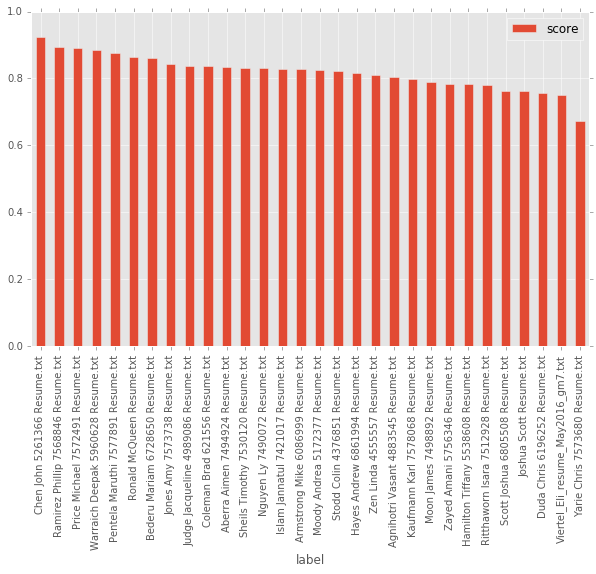

In [64]:
%matplotlib inline
import pandas as pd
import matplotlib
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

result = []
for i in range(len(candidate)):
    result.append((candidate[i]['name'], candidate[i]['distance']))
result = sorted(result, key=lambda x: x[1], reverse=True)

df = pd.DataFrame(result, columns=['label', 'score'])
df[:50].plot(kind='bar', x='label', y='score');